In [65]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# import seaborn as sns
# sns.set_style("white")

from sklearn.model_selection import train_test_split

from PIL import Image

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, concatenate, Dropout, Conv3D, Conv3DTranspose, MaxPooling3D,BatchNormalization
import os
from tqdm import tqdm_notebook



from tensorflow import cast, uint32, where
import keras
import keras.backend as K
import tensorflow as tf
import random

In [66]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

In [67]:
img_size_ori = 500
img_size_target = 256

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return img.resize((img_size_target, img_size_target), Image.ANTIALIAS)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
# def downsample(img):
#     if img_size_ori == img_size_target:
#         return img
#     return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
#     #return img[:img_size_ori, :img_size_ori]

In [68]:
out = os.listdir("TIFF black")
inp = os.listdir("TIFF 8bit")

out_data = np.zeros((53, 32, img_size_target, img_size_target))
in_data = np.zeros((53,32,img_size_target,img_size_target))
for i in range(1,54):
    for j in range(1,33):
        out_data[i-1,j-1] = upsample(load_img(f"TIFF black/EYE{i:03} slice {j} black.tif", color_mode='grayscale'))
        in_data[i-1,j-1] = upsample(load_img(f"TIFF 8bit/EYE{i:03} slice {j} uint8.tif", color_mode='grayscale'))
#     for j in range(14,46):
#         out_data[i-1+53, j-14] = upsample(load_img(f"TIFF black/EYE{i:03} slice {j} black.tif", color_mode='grayscale'))
#         in_data[i-1+53, j-14] = upsample(load_img(f"TIFF 8bit/EYE{i:03} slice {j} uint8.tif", color_mode='grayscale'))
# for i in range(1,54):
#     for j in range(1,33):
#         in_data[i-1,j-1] = upsample(load_img(f"TIFF 8bit/EYE{i:03} slice {j} uint8.tif", color_mode='grayscale'))
    
    
#plt.imshow(in_data[0])
        


In [69]:
out_data = np.array(out_data)/255
inp_data = np.array(in_data)/255

In [70]:
in_data[0].shape

(32, 256, 256)

In [71]:
out_data = np.array(out_data)
in_data = np.array(in_data)

In [72]:
in_data[0].shape

(32, 256, 256)

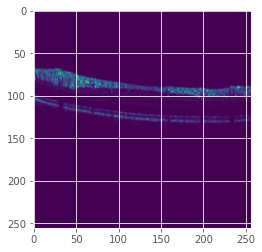

In [73]:
plt.imshow(in_data[0,5])

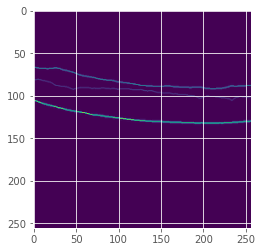

In [74]:
plt.imshow(out_data[0,5])

In [105]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation="relu", padding="same" , kernel_initializer = 'uniform' )(input_layer)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    # 64 -> 32
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool1)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    # 32 -> 16
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool2)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)
    
    # 16 -> 8
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool3)
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv4)
    pool4 = MaxPooling3D((2, 2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    # Middle
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool4)
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(convm)

    # 8 -> 16
    deconv4 = Conv3DTranspose(start_neurons * 8, (3, 3, 3), strides=(2, 2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.2)(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv4)

    # 16 -> 32
    deconv3 = Conv3DTranspose(start_neurons * 4, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.2)(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv3)

    # 32 -> 64
    deconv2 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.2)(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv2)

    # 64 -> 128
    deconv1 = Conv3DTranspose(start_neurons * 1, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.2)(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv3D(1, (1,1,1), padding="same", activation="sigmoid", kernel_initializer = 'uniform')(uconv1)
    
    return output_layer

input_layer = Input((32,img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)

In [106]:
model = Model(input_layer, output_layer)

In [107]:
from keras.metrics import MeanIoU

In [108]:
from tensorflow.keras.metrics import Precision, Recall, MeanIoU, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy

In [174]:
model.compile(loss=weightedBinCrossEntr(), optimizer="adam", metrics=[Recall(),Precision(),
                                                                    MeanIoU(num_classes=2), "accuracy", "AUC"])

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d_69 (Conv3D)             (None, 32, 256, 256  560         ['input_5[0][0]']                
                                , 20)                                                             
                                                                                                  
 conv3d_70 (Conv3D)             (None, 32, 256, 256  10820       ['conv3d_69[0][0]']              
                                , 20)                                                       

In [126]:
x_train, x_test, y_train, y_test = train_test_split(in_data.reshape(-1, 32,img_size_target, img_size_target, 1), 
    out_data.reshape(-1, 32, img_size_target, img_size_target, 1),  test_size=0.1)

In [127]:
np.array(x_train).shape

(47, 32, 256, 256, 1)

In [128]:
def diceLoss():  
    def f(targets, inputs, smooth=1e-6):
        inputs = K.flatten(inputs)
        targets = cast(K.flatten(targets), tf.float32)

        intersection = K.sum(tf.multiply(targets, inputs))
        dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        return 1 - dice
    return f

def DiceBCE():
    def f(targets, inputs, smooth=1e-6):
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        targets=cast(targets,tf.float32)
        print(inputs[:10])
        print(targets[:10])
        BCE =  keras.losses.binary_crossentropy(targets, inputs)
        intersection = K.sum(tf.multiply(cast(targets,tf.float32), cast(inputs, tf.float32)))  
        dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    return f


In [143]:
def weightedBinCrossEntr(positive_weight=5):
    def f(y_true, y_pred, w = positive_weight):
        y_true = cast(y_true, tf.float32)
        weights = tf.ones_like(y_pred)  # (None,512,512,1)
        weights = tf.where(y_pred > 0.5, w * weights, weights)
        out = keras.losses.binary_crossentropy(y_true, y_pred)  # (None,512,512)
        out = K.expand_dims(out, axis=-1) * weights  # (None,512,512,1)* (None,512,512,1)
        return K.mean(out)
    return f

In [144]:
#x_train = (lambda x(x_train)
#x_test = (lambda x: 1.0*(x>0.02))(x_test)
y_train = (lambda x: 1*(x>0.03))(y_train)
y_test =(lambda x: 1*(x>0.03))(y_test)

In [145]:
x_train[0].shape

(32, 256, 256, 1)

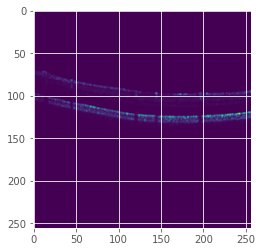

In [146]:
plt.imshow(x_train[0,0].reshape(256,256))

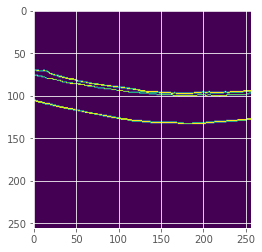

In [147]:
plt.imshow(y_train[0,0].reshape(256,256))

In [148]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./3D_unet.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 6

history = model.fit(x_train, y_train,
                    validation_data=[x_test, y_test], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 0.0974 - recall_6: 0.3053 - precision_6: 0.7601 - mean_io_u_6: 0.4910 - accuracy: 0.9858 - auc: 0.9690
Epoch 1: val_loss improved from inf to 0.10838, saving model to ./3D_unet.model
INFO:tensorflow:Assets written to: ./3D_unet.model/assets
8/8 [==============================] - 29s 3s/step - loss: 0.0974 - recall_6: 0.3053 - precision_6: 0.7601 - mean_io_u_6: 0.4910 - accuracy: 0.9858 - auc: 0.9690 - val_loss: 0.1084 - val_recall_6: 0.5099 - val_precision_6: 0.8264 - val_mean_io_u_6: 0.4909 - val_accuracy: 0.9891 - val_auc: 0.9895 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.1248 - recall_6: 0.5190 - precision_6: 0.7818 - mean_io_u_6: 0.4910 - accuracy: 0.9887 - auc: 0.9801
Epoch 2: val_loss did not improve from 0.10838
8/8 [==============================] - 16s 2s/step - loss: 0.1248 - recall_6: 0.5190 - precision_6: 0.7818 - mean_io_u_6: 0.4910 - accuracy: 0.9887 - auc: 0.9801 - v

In [155]:
model = load_model('./3D_unet.model', custom_objects={"f":weightedBinCrossEntr()})

In [156]:
predicteds = model.predict(x_test)
#plt.imshow(predicteds[0].reshape(1,512,512,1))


In [157]:
predicteds.shape

(6, 32, 256, 256, 1)

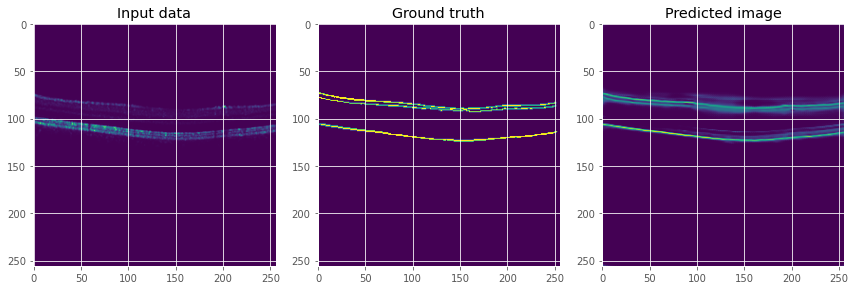

In [161]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,12))

ax3.imshow(predicteds[0,0].squeeze())
ax3.set_title("Predicted image")

ax1.imshow(x_test[0,0].reshape(256,256))
ax1.set_title("Input data")

ax2.imshow(y_test[0,0].reshape(256,256))
ax2.set_title("Ground truth")

fig.tight_layout()

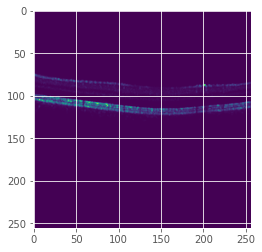

In [159]:
plt.imshow(x_test[0,0].reshape(256,256))

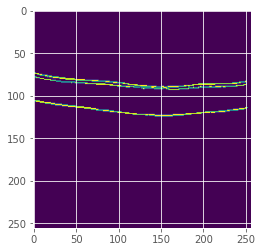

In [160]:
plt.imshow(y_test[0,0].reshape(256,256))

In [162]:
import pickle

In [164]:
fh = open("historiesfile.txt", "rb")
histories = pickle.load(fh)

ValueError: Unknown loss function: f. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [165]:
histories = { "BCE" : {"Precision":0.91409, "Recall":0.907954, "AUC":0.999263, "Mean IoU":0.661571},
             "wBCE-3":{"Precision":0.918204, "Recall":0.899749, "AUC":0.999312, "Mean IoU":0.594243},
             "wBCE-10":{"Precision":0.915452, "Recall":0.890431, "AUC":0.999037, "Mean IoU":0.563584},
             "wBCE-17":{"Precision":0.924417, "Recall":0.891063, "AUC":0.99896, "Mean IoU":0.498943},
             "wBCE-25":{"Precision":0.095021, "Recall":0.48759, "AUC":0.578404, "Mean IoU":0.491814},
             "wBCE-40":{"Precision":0.917349, "Recall":0.883703, "AUC":0.998537, "Mean IoU":0.501471},
             "diceLoss":{"Precision":0.729209, "Recall":0.923778, "AUC":0.963287, "Mean IoU":0.836579},
             "wDice-3":{"Precision":0.860186, "Recall":0.890365, "AUC":0.948928, "Mean IoU":0.884593},
             "wDice-10":{"Precision":0.881486, "Recall":0.906755, "AUC":0.956349, "Mean IoU":0.899613},
             "wDice-17":{"Precision":0.881792, "Recall":0.906569, "AUC":0.957259, "Mean IoU":0.899269},
             "wDice-25":{"Precision":0.88779, "Recall":0.90858, "AUC":0.958364, "Mean IoU":0.902758},
             "wDice-40":{"Precision":0.86201, "Recall":0.894641, "AUC":0.950092, "Mean IoU":0.887416},
             "DiceBCE":{"Precision":0.915831, "Recall":0.927456, "AUC":0.989068, "Mean IoU":0.697196},
             "IoULoss":{"Precision":0.884173, "Recall":0.905075, "AUC":0.955582, "Mean IoU":0.899912}}
             

In [171]:
n = np.argmin(history.history["val_loss"])
precision = history.history['val_precision_6'][10]
recall =  history.history['val_recall_6'][10]
AUC = history.history['val_auc'][10]
mean_to_IoU = history.history["val_mean_io_u_6"][10]

histories["3DwBCE-5"] =  {"Precision":precision, "Recall":recall, "AUC":AUC, "Mean IoU":mean_to_IoU}



In [172]:
names = []
precisions = []
recalls=[]
aucs = []
meanIoUs = []

for name in histories.keys():
    names.append(name)
    precisions.append(histories[name]["Precision"])
    recalls.append(histories[name]["Recall"])
    aucs.append(histories[name]["AUC"])
    meanIoUs.append(histories[name]["Mean IoU"])
    

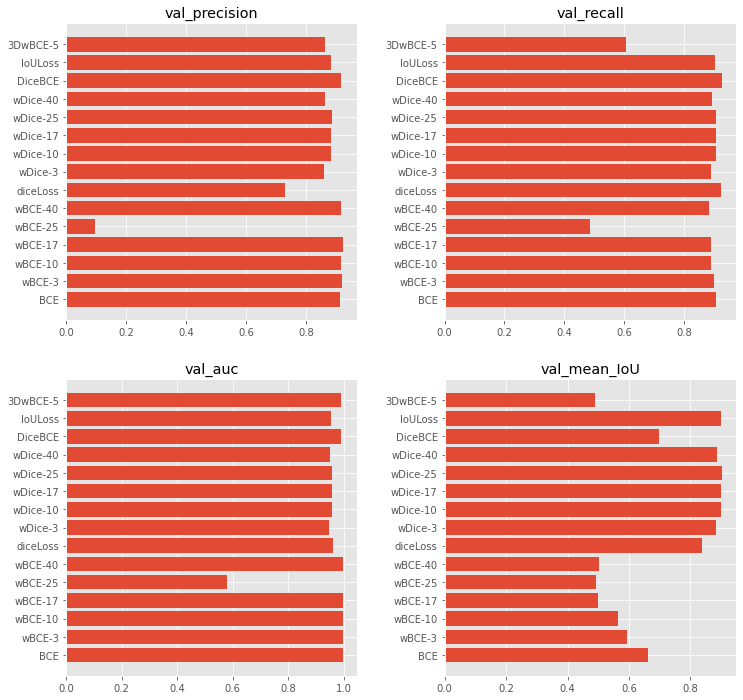

In [173]:
fig, ((ax00, ax01),(ax10,ax11)) = plt.subplots(2,2, figsize=(12,12))
ax00.set_title("val_precision")
ax00.barh(names, precisions)

ax01.set_title("val_recall")
ax01.barh(names, recalls)

ax10.set_title("val_auc")
ax10.barh(names, aucs)

ax11.set_title("val_mean_IoU")
ax11.barh(names, meanIoUs)

# fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.2)
fig.savefig("my_fig.jpeg")

In [32]:
import os
os.listdir("TIFF black")

['EYE001 slice 1 black.tif',
 'EYE001 slice 10 black.tif',
 'EYE001 slice 11 black.tif',
 'EYE001 slice 12 black.tif',
 'EYE001 slice 13 black.tif',
 'EYE001 slice 14 black.tif',
 'EYE001 slice 15 black.tif',
 'EYE001 slice 16 black.tif',
 'EYE001 slice 17 black.tif',
 'EYE001 slice 18 black.tif',
 'EYE001 slice 19 black.tif',
 'EYE001 slice 2 black.tif',
 'EYE001 slice 20 black.tif',
 'EYE001 slice 21 black.tif',
 'EYE001 slice 22 black.tif',
 'EYE001 slice 23 black.tif',
 'EYE001 slice 24 black.tif',
 'EYE001 slice 25 black.tif',
 'EYE001 slice 26 black.tif',
 'EYE001 slice 27 black.tif',
 'EYE001 slice 28 black.tif',
 'EYE001 slice 29 black.tif',
 'EYE001 slice 3 black.tif',
 'EYE001 slice 30 black.tif',
 'EYE001 slice 31 black.tif',
 'EYE001 slice 32 black.tif',
 'EYE001 slice 33 black.tif',
 'EYE001 slice 34 black.tif',
 'EYE001 slice 35 black.tif',
 'EYE001 slice 36 black.tif',
 'EYE001 slice 37 black.tif',
 'EYE001 slice 38 black.tif',
 'EYE001 slice 39 black.tif',
 'EYE001 slic

In [9]:
print(1345/7, 1345/7*6)
    

192.14285714285714 1152.857142857143


In [11]:
a = (3542.347-1345)
print( a / (0.00260508+0.02375803) * 0.02375803 )
print( a / (0.00260508+0.02375803) * 0.00260508 )

1980.2153822674945
217.13161773250582


In [12]:
c = 1152.857+217.13161
d = 192.143 + 1980.21538
print (c/(c+d)*100,"%")
print (d/(c+d)*100,"%")

38.67460228677372 %
61.32539771322628 %


In [16]:
1340*465

623100

In [175]:
histories["DiceBCE"]["Recall"]/histories["3DwBCE-5"]["Recall"]

1.5304153894865862

In [177]:
histories["DiceBCE"]["AUC"]/histories["3DwBCE-5"]["AUC"]

0.9981942469012849